In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

In [2]:
table = pd.read_csv('../data/main_table_221115.csv')

C:\Users\richa\AppData\Local\Temp\ipykernel_8440\1687289751.py:1: DtypeWarning: Columns (60) have mixed types. Specify dtype option on import or set low_memory=False.
  table = pd.read_csv('../data/main_table_221115.csv')


In [3]:
df_array = []

t = pd.read_csv('../data/gwas_all_hits_5e-08.csv')
t['type'] = 'gwas'
df_array.append(t)

t = pd.read_csv('../data/aff_ms_all_hits.csv')
t['type'] = 'aff_ms'
df_array.append(t)

t = pd.read_csv('../data/transcriptomics_all_hits_0.05.csv')
t['type'] = 'transcriptomics'
df_array.append(t)

t = pd.read_csv('../data/crispr_all_hits.csv')
t['type'] = 'crispr'
df_array.append(t)

hits_df = pd.concat(df_array).reset_index(drop=True)

In [4]:
hits_df

,gene_ncbi,pubmed_id,mentioned,mentioned_citations,hit,type
0,9722.0,16648850,True,True,True,gwas
1,5654.0,17053108,True,True,True,gwas
2,79068.0,17434869,True,True,True,gwas
3,54901.0,17460697,True,True,True,gwas
4,6934.0,17460697,False,True,True,gwas
...,...,...,...,...,...,...
792822,2033.0,31801065,False,False,True,crispr
792823,55670.0,31801065,False,False,True,crispr
792824,84219.0,31801065,False,False,True,crispr
792825,892.0,31801065,False,False,True,crispr


In [5]:
#hits_df.to_csv('../data/combined_hits.csv', index=False)

Binary table

In [5]:
binary_props = ['mouse_pheno', 'mendelian_inheritance', 'mouse', 'rat',
       'c_elegans', 'd_melanogaster', 'yeast', 'zebrafish', 'primate_specific',
       'nextprot_evidence', 'hpa_evidence', 'uniprot_evidence',
       'membrane_protein', 'antibody', 'approved_ih', 'approved_if',
       'idg_understudied', 'plasmid', 'compound', 'previously_patented',
               'loss_of_function_intolerant', 'druggable', 'defined_hugo']

In [11]:
%%time
alpha = 0.05
crit = scipy.stats.norm.ppf(1-(alpha/2))
result_array = []
for exp_type in ['gwas', 'crispr', 'transcriptomics', 'aff_ms']:
    hits = set(hits_df[hits_df['type'] == exp_type]['gene_ncbi'])
    mentioned_hits = set(hits_df[(hits_df['type'] == exp_type) & hits_df['mentioned']]['gene_ncbi'])
    non_mentioned_hits = hits - mentioned_hits

    table_slice = table[table['gene_ncbi'].isin(hits)].copy()
    table_slice['mentioned'] = table_slice['gene_ncbi'].isin(mentioned_hits)

    for prop in binary_props:
        cont_table = (
        table_slice.groupby(['mentioned', prop])
        .count()
        .reset_index()
        .pivot(index='mentioned', columns=prop, values='gene_ncbi')
        .fillna(0.0)
        )
        try:
            odds_ratio, p = scipy.stats.fisher_exact(cont_table.values)
            if (prop == 'compound') & (exp_type == 'transcriptomics'):
                print(cont_table)

            a,b,c,d = cont_table.values.flatten()
            low = np.exp(np.log(odds_ratio) - crit*np.sqrt((1/a) + (1/b) + (1/c) + (1/d)))
            upp = np.exp(np.log(odds_ratio) + crit*np.sqrt((1/a) + (1/b) + (1/c) + (1/d)))
        except:
            print(exp_type, prop, 'invalid contingency table')
            odds_ratio, p = np.inf, np.nan
            low = np.inf
            upp = np.inf
        
        result = pd.DataFrame({'type':[exp_type], 
                               'property':[prop], 
                               'odds_ratio':[odds_ratio], 
                               'lb':[low],
                               'ub':[upp],
                               'p':[p]})
        result_array.append(result)
        
result_df = pd.concat(result_array).reset_index(drop=True)

gwas defined_hugo invalid contingency table


<timed exec>:26: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:26: RuntimeWarning: invalid value encountered in double_scalars
<timed exec>:27: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:26: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:26: RuntimeWarning: invalid value encountered in double_scalars
<timed exec>:27: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:26: RuntimeWarning: divide by zero encountered in log
<timed exec>:26: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:27: RuntimeWarning: divide by zero encountered in log
<timed exec>:27: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:27: RuntimeWarning: invalid value encountered in double_scalars
<timed exec>:26: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:26: RuntimeWarning: invalid value encountered in double_scalars
<timed exec>

compound   False  True
mentioned             
False      13697  4437
True          67    94
transcriptomics defined_hugo invalid contingency table


<timed exec>:26: RuntimeWarning: divide by zero encountered in log
<timed exec>:26: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:27: RuntimeWarning: divide by zero encountered in log
<timed exec>:27: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:27: RuntimeWarning: invalid value encountered in double_scalars


CPU times: total: 19.4 s
Wall time: 19.3 s


<timed exec>:26: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:26: RuntimeWarning: invalid value encountered in double_scalars
<timed exec>:27: RuntimeWarning: divide by zero encountered in double_scalars


In [7]:
result_df[result_df['property'] == 'defined_hugo']

,type,property,odds_ratio,lb,ub,p
22,gwas,defined_hugo,inf,inf,inf,NaN
45,crispr,defined_hugo,inf,NaN,inf,1.0
68,transcriptomics,defined_hugo,inf,inf,inf,NaN
91,aff_ms,defined_hugo,inf,NaN,inf,1.0


In [9]:
result_df[result_df['property'] == 'compound']

,type,property,odds_ratio,lb,ub,p
18,gwas,compound,1.734,1.345,2.236,2.405e-05
41,crispr,compound,1.401,0.525,3.737,5.915e-01
64,transcriptomics,compound,4.331,3.160,5.936,9.939e-20
87,aff_ms,compound,1.988,1.582,2.498,8.103e-09


In [34]:
result_df = result_df[result_df['property'] != 'defined_hugo']

In [35]:
asterisks = []
for p in result_df['p']:
    asterisk = ''
    if p < 0.05:
        asterisk = asterisk + '*'
    if p < 0.01:
        asterisk = asterisk + '*'
    if p < 0.001:
        asterisk = asterisk + '*'
    asterisks.append(asterisk)
    
result_df['asterisks'] = asterisks

In [36]:
result_df['text'] = result_df['odds_ratio'].round(3).astype(str) + result_df['asterisks'] + \
' (' + result_df['lb'].round(3).astype(str) + ', ' + \
+ result_df['ub'].round(3).astype(str) +')'

In [37]:
#result_df['text'] = result_df['odds_ratio'].round(3).astype(str) + result_df['asterisks']
result_df.to_csv('../data/binary_table_eval_230728.csv', index=False)

In [38]:
result_pivot = result_df.pivot(index='property', columns='type', values='text')
result_pivot.to_csv('../data/binary_table_eval_format_230728.csv')

In [39]:
len(result_pivot)

22

In [40]:
result_pivot

type,aff_ms,crispr,gwas,transcriptomics
property,,,,
antibody,"2.617* (1.074, 6.379)","0.735 (0.169, 3.201)","0.838 (0.535, 1.312)","2.357* (1.156, 4.806)"
approved_if,"2.232*** (1.557, 3.2)","0.812 (0.304, 2.166)","0.762* (0.585, 0.991)","3.007*** (1.961, 4.612)"
approved_ih,"1.391* (1.061, 1.823)","1.235 (0.463, 3.295)","1.099 (0.846, 1.428)","2.029*** (1.425, 2.888)"
c_elegans,"0.909 (0.7, 1.181)","1.385 (0.493, 3.888)","0.81 (0.576, 1.139)","0.978 (0.646, 1.481)"
compound,"1.988*** (1.582, 2.498)","1.401 (0.525, 3.737)","1.734*** (1.345, 2.236)","4.331*** (3.16, 5.936)"
d_melanogaster,"1.224 (0.97, 1.543)","1.54 (0.596, 3.976)","0.723* (0.53, 0.986)","1.086 (0.756, 1.56)"
druggable,"1.232 (0.936, 1.622)","1.529 (0.544, 4.295)","2.156*** (1.666, 2.791)","2.948*** (2.159, 4.026)"
hpa_evidence,"2.143*** (1.561, 2.943)","1.45 (0.517, 4.071)","1.224 (0.936, 1.601)","2.432*** (1.676, 3.527)"
idg_understudied,"0.0 (0.0, nan)","4.365 (0.576, 33.056)","0.83 (0.304, 2.261)","0.0 (0.0, nan)"


Continuous table eval

In [41]:
continuous_props = \
['n_pubs', 'n_synonyms', 'n_gwas', 'n_biocarta', 'n_reactome',
       'n_hpo', 'n_wikipathways', 'n_pid', 'n_kegg', 'n_go', 
 'p_de', 'normalized_gravy', 
 'gene_length', 'detectable_portion', 'tissue_median', 'hela_expression',
'n_mouse_pubs', 'n_rat_pubs', 'n_d_melanogaster_pubs', 
 'n_zebrafish_pubs', 'n_c_elegans_pubs','n_yeast_pubs']

In [42]:
%%time

result_array = []
for exp_type in ['gwas', 'crispr', 'transcriptomics', 'aff_ms']:
    hits = set(hits_df[hits_df['type'] == exp_type]['gene_ncbi'])
    mentioned_hits = set(hits_df[(hits_df['type'] == exp_type) & hits_df['mentioned']]['gene_ncbi'])
    non_mentioned_hits = hits - mentioned_hits

    table_slice = table[table['gene_ncbi'].isin(hits)].copy()
    table_slice['mentioned'] = table_slice['gene_ncbi'].isin(mentioned_hits)

    for prop in continuous_props:
        prop_dict = table_slice.dropna(subset=[prop]).groupby('mentioned')[prop].apply(list).to_dict()
        a = np.array(prop_dict.get(False))
        b = np.array(prop_dict.get(True))
        
        u, p = scipy.stats.mannwhitneyu(b, a, alternative='two-sided')
        result = pd.DataFrame({'type':[exp_type], 
                               'property':[prop], 
                               'n_unmentioned':[len(a)], 
                               'n_mentioned':[len(b)],
                               'u':[u],
                               'p':[p]})
        result_array.append(result)
        
result_df = pd.concat(result_array).reset_index(drop=True)

CPU times: total: 844 ms
Wall time: 850 ms


In [43]:
result_df['f'] = result_df['u']/(result_df['n_unmentioned']*result_df['n_mentioned'])

In [44]:
asterisks = []
for p in result_df['p']:
    asterisk = ''
    if p < 0.05:
        asterisk = asterisk + '*'
    if p < 0.01:
        asterisk = asterisk + '*'
    if p < 0.001:
        asterisk = asterisk + '*'
    asterisks.append(asterisk)
    
result_df['asterisks'] = asterisks

In [45]:
result_df['text'] = result_df['f'].round(3).astype(str) + result_df['asterisks']
result_df.to_csv('../data/continuous_table_eval_230728.csv', index=False)

In [46]:
result_pivot = result_df.pivot(index='property', columns='type', values='text')
result_pivot.to_csv('../data/continuous_table_eval_format_230728.csv')

In [47]:
len(result_pivot)

22

In [48]:
result_pivot

type,aff_ms,crispr,gwas,transcriptomics
property,,,,
detectable_portion,0.551***,0.593,0.438***,0.556*
gene_length,0.544**,0.58,0.565***,0.532
hela_expression,0.602***,0.491,0.44**,0.564**
n_biocarta,0.57***,0.593**,0.531**,0.655***
n_c_elegans_pubs,0.597***,0.785**,0.482,0.616**
n_d_melanogaster_pubs,0.62***,0.704*,0.566,0.826***
n_go,0.666***,0.652*,0.619***,0.788***
n_gwas,0.528,0.564,0.619***,0.643***
n_hpo,0.573***,0.559,0.598***,0.64***


Clustering

In [5]:
binary_props = ['mouse_pheno', 'mendelian_inheritance', 'mouse', 'rat',
       'c_elegans', 'd_melanogaster', 'yeast', 'zebrafish', 'primate_specific',
       'nextprot_evidence', 'hpa_evidence', 'uniprot_evidence',
       'membrane_protein', 'antibody', 'approved_ih', 'approved_if',
       'idg_understudied', 'plasmid', 'compound', 'previously_patented',
               'loss_of_function_intolerant', 'druggable', 'defined_hugo']
continuous_props = \
['n_pubs', 'n_synonyms', 'n_gwas', 'n_biocarta', 'n_reactome',
       'n_hpo', 'n_wikipathways', 'n_pid', 'n_kegg', 'n_go', 
 'p_de', 'normalized_gravy', 
 'gene_length', 'detectable_portion', 'tissue_median', 'hela_expression',
'n_mouse_pubs', 'n_rat_pubs', 'n_d_melanogaster_pubs', 
 'n_zebrafish_pubs', 'n_c_elegans_pubs','n_yeast_pubs']

In [6]:
table_slice = table[table['protein_coding']][continuous_props].rank(axis=0, 
                                                              pct=True, 
                                                              method='min', 
                                                              na_option='top').join(
        table[table['protein_coding']][binary_props].fillna(False)).join(
    table['symbol_from_nomenclature_authority'])
table_slice = table_slice.set_index('symbol_from_nomenclature_authority')

In [7]:
table_slice = table_slice.rename(columns={'mouse_pheno':'Has associated mouse phenotype', 
                                          'mendelian_inheritance':'Mendelian inheritance',
                                          'mouse':'Homolog in mouse',
                                          'rat':'Homolog in rat',
                                          'c_elegans':'Homolog in C. elegans',
                                          'd_melanogaster':'Homolog in D. melanogaster',
                                          'yeast':'Homolog in yeast',
                                          'zebrafish':'Homolog in zebrafish',
                                          'primate_specific':'Specific to primates',
                                          'nextprot_evidence':'Evidence protein exists (neXtProt)',
                                          'hpa_evidence':'Evidence protein exists (HPA)',
                                          'uniprot_evidence':'Evidence protein exists (UniProt)',
                                          'membrane_protein':'Membrane protein',
                                          'antibody':'Antibody available',
                                          'approved_ih':'Antibody approved (Immunohistochemistry)',
                                          'approved_if':'Antibody approved (Immunofluorescence)',
                                          'idg_understudied':'Understudied according to IDG',
                                          'plasmid':'Plasmid available',
                                          'compound':'Compound known to affect gene activity',
                                          'previously_patented':'Previously patented',
                                          'loss_of_function_intolerant':'Loss of function intolerant',
                                          'druggable':'Druggable',
                                          'defined_hugo':'Defined HGNC nomenclature',
                                          'n_pubs':'Number of articles about gene', 
                                          'n_synonyms':'Number of synonyms', 
                                          'n_gwas':'Number of GWAS annotations', 
                                          'n_biocarta':'Number of BioCarta annotations', 
                                          'n_reactome':'Number of Reactome annotations', 
                                          'n_hpo':'Number of HPO annotations', 
                                          'n_wikipathways':'Number of WikiPathways annotations', 
                                          'n_pid':'Number of PID annotations', 
                                          'n_kegg':'Number of KEGG annotations', 
                                          'n_go':'Number of GO annotations', 
                                          'p_de':'Probability of differential expression', 
                                          'normalized_gravy':'GRAVY score', 
                                          'gene_length':'Gene length', 
                                          'detectable_portion':'Proportion of tissues with detectable RNA expression', 
                                          'tissue_median':'Median RNA expression across tissues', 
                                          'hela_expression':'RNA expression in HeLa', 
                                          'n_mouse_pubs':'Number of articles about mouse homolog', 
                                          'n_rat_pubs':'Number of articles about rat homolog', 
                                          'n_d_melanogaster_pubs':'Number of articles about D. melanogaster homolog', 
                                          'n_zebrafish_pubs':'Number of articles about zebrafish homolog', 
                                          'n_c_elegans_pubs':'Number of articles about C. elegans homolog', 
                                          'n_yeast_pubs':'Number of articles about yeast homolog'})

In [8]:
table_slice

,Number of articles about gene,Number of synonyms,Number of GWAS annotations,Number of BioCarta annotations,Number of Reactome annotations,Number of HPO annotations,Number of WikiPathways annotations,Number of PID annotations,Number of KEGG annotations,Number of GO annotations,...,Antibody available,Antibody approved (Immunohistochemistry),Antibody approved (Immunofluorescence),Understudied according to IDG,Plasmid available,Compound known to affect gene activity,Previously patented,Loss of function intolerant,Druggable,Defined HGNC nomenclature
symbol_from_nomenclature_authority,,,,,,,,,,,,,,,,,,,,,
A1BG,8.010e-01,6.824e-01,5.197e-05,5.197e-05,7.231e-01,5.197e-05,5.197e-05,5.197e-05,5.197e-05,2.781e-01,...,True,True,False,False,False,False,True,False,True,True
A2M,9.611e-01,6.824e-01,4.031e-01,5.197e-05,8.982e-01,5.197e-05,5.197e-05,8.696e-01,7.314e-01,9.070e-01,...,True,True,False,False,True,True,True,False,True,True
NAT1,9.216e-01,6.824e-01,7.061e-01,5.197e-05,4.794e-01,5.197e-05,5.197e-05,5.197e-05,7.314e-01,1.835e-01,...,True,True,False,False,True,True,True,False,True,True
NAT2,9.850e-01,5.291e-01,9.930e-01,5.197e-05,4.794e-01,5.197e-05,7.774e-01,5.197e-05,7.314e-01,1.835e-01,...,True,False,False,False,True,True,True,False,True,True
SERPINA3,9.269e-01,6.824e-01,6.508e-01,5.197e-05,7.231e-01,5.197e-05,8.497e-01,5.197e-05,5.197e-05,6.503e-01,...,True,True,False,False,False,True,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-,5.197e-05,5.197e-05,5.014e-01,5.197e-05,5.197e-05,5.197e-05,5.197e-05,5.197e-05,5.197e-05,5.197e-05,...,False,False,False,False,False,False,False,False,False,False
-,5.197e-05,5.197e-05,5.197e-05,5.197e-05,5.197e-05,5.197e-05,5.197e-05,5.197e-05,5.197e-05,5.197e-05,...,False,False,False,False,False,False,False,False,False,False
-,5.197e-05,5.197e-05,5.197e-05,5.197e-05,5.197e-05,5.197e-05,5.197e-05,5.197e-05,5.197e-05,5.197e-05,...,False,False,False,False,False,False,False,False,False,False


C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


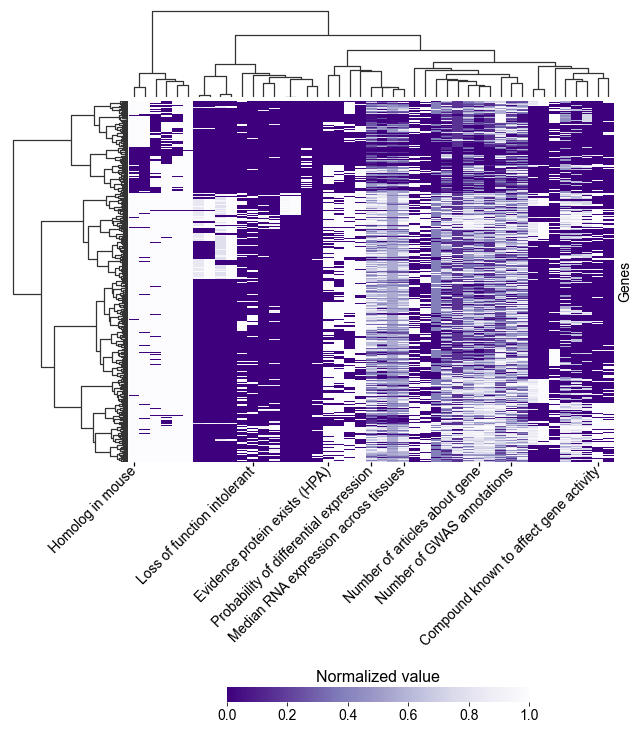

In [11]:
genes_to_highlight = ['GPR173', 'TNF', 'SFPQ', 'FAM47B']

g = sns.clustermap(table_slice.dropna().astype(float), 
                   method='ward', 
                   cmap='Purples_r',
                   xticklabels=1, yticklabels=950, figsize=(10,10),  
                   cbar_kws={'orientation':'horizontal'}, tree_kws=dict(linewidths=1.25))
g.ax_heatmap.set_ylabel(None)
g.ax_cbar.set_position((0.32, 0.02, 0.42, 0.02))
g.ax_cbar.set_title(r'Normalized value', fontsize=16)
g.ax_cbar.tick_params(labelsize=14)
g.ax_heatmap.tick_params(labelsize=14, axis='both', width=1.25)
g.ax_heatmap.tick_params(rotation=0, axis='y')

all_xtick_labels = g.ax_heatmap.get_xticklabels()
xtick_labels = []
pos_array = []

pref_features = ['Loss of function intolerant',
                 'Homolog in mouse', 
                 'Evidence protein exists (HPA)', 
                 'Probability of differential expression', 
                 'Median RNA expression across tissues', 
                 'Number of articles about gene', 
                 'Number of GWAS annotations', 
                 'Compound known to affect gene activity']

for text_obj, index in zip(all_xtick_labels, range(len(all_xtick_labels))):
    label = text_obj.get_text()
    pos = text_obj.get_position()[0]
    if label in pref_features:
        xtick_labels.append(label)
        pos_array.append(pos)
        
g.ax_heatmap.set_xticks(pos_array, labels=xtick_labels)
g.ax_heatmap.set_xticklabels(labels=g.ax_heatmap.xaxis.get_ticklabels(), 
                             rotation=45, ha='right', va='center', rotation_mode='anchor')
g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_ylabel('Genes', fontsize=14, rotation=90)

#g.ax_heatmap.set_yticks(np.arange(len(g.data2d))[g.data2d.index.isin(genes_to_highlight)], 
#                        labels=g.data2d.index[g.data2d.index.isin(genes_to_highlight)])

plt.savefig('../img/property_clustering_binary_rank.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/property_clustering_binary_rank.pdf', bbox_inches='tight')

export.image('general', p='figures/property_clustering_binary_rank.pdf', date=True)
export.raster_image('general', p='figures/property_clustering_binary_rank.png', date=True, dpi=600)

C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


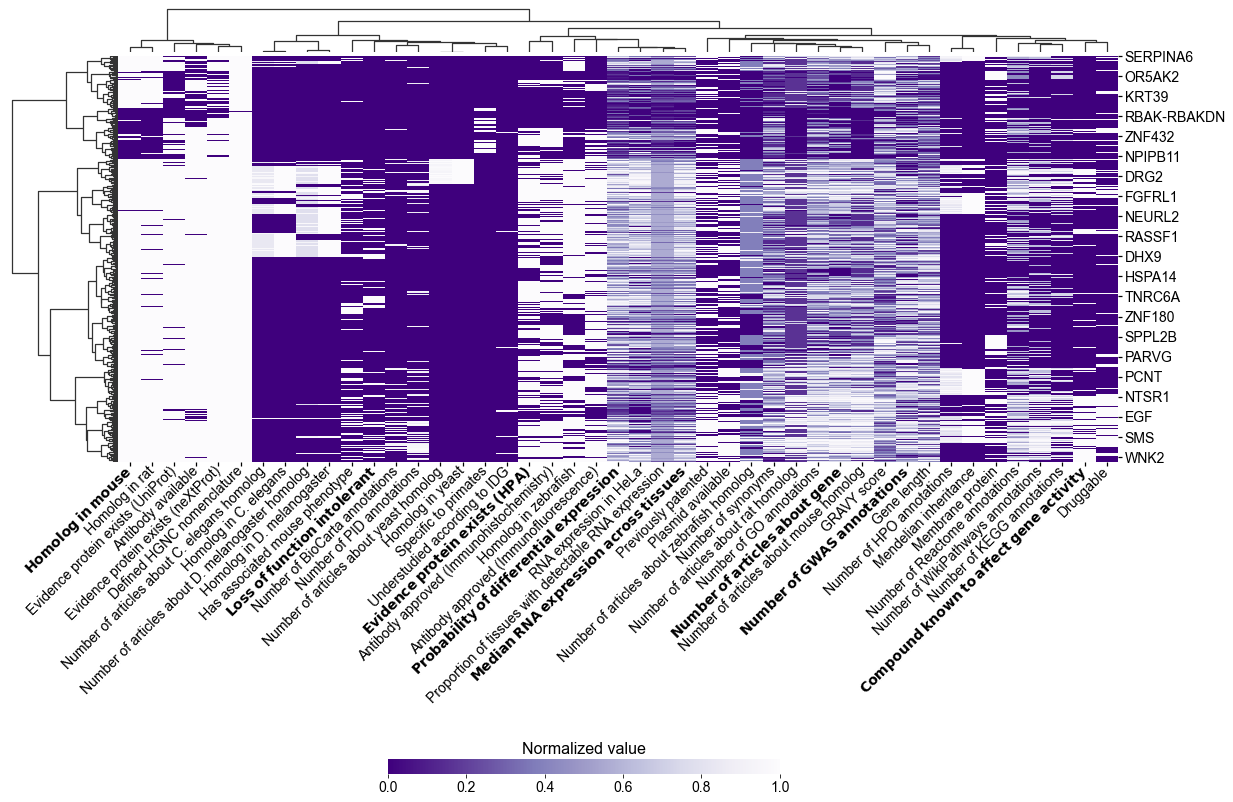

In [76]:
genes_to_highlight = ['GPR173', 'TNF', 'SFPQ', 'FAM47B']

g = sns.clustermap(table_slice.dropna().astype(float), 
                   method='ward', 
                   cmap='Purples_r',
                   xticklabels=1, yticklabels=950, figsize=(17,10),  
                   cbar_kws={'orientation':'horizontal'}, tree_kws=dict(linewidths=1.25), 
                   dendrogram_ratio=(0.1,0.1))
g.ax_heatmap.set_ylabel(None)
#g.ax_cbar.set_position((0.32, -0.18, 0.42, -0.08))
g.ax_cbar.set_title(r'Normalized value', fontsize=16)
g.ax_cbar.tick_params(labelsize=14)
g.ax_heatmap.tick_params(labelsize=14, axis='both', width=1.25)
g.ax_heatmap.tick_params(rotation=0, axis='y')
g.ax_cbar.set_position((0.32, -0.08, 0.32, 0.02))

all_xtick_labels = g.ax_heatmap.get_xticklabels()
xtick_labels = []
pos_array = []

pref_features = ['Loss of function intolerant',
                 'Homolog in mouse', 
                 'Evidence protein exists (HPA)', 
                 'Probability of differential expression', 
                 'Median RNA expression across tissues', 
                 'Number of articles about gene', 
                 'Number of GWAS annotations', 
                 'Compound known to affect gene activity']

all_xtick_labels = [x.get_text() for x in all_xtick_labels]
for label, index in zip(all_xtick_labels, range(len(all_xtick_labels))):
    if label in pref_features:
        all_xtick_labels[index] = r'${\bf' + label.replace(' ', '\:') + '}$'
        
g.ax_heatmap.set_xticklabels(labels=all_xtick_labels, 
                             rotation=45, ha='right', va='center', rotation_mode='anchor')

#g.ax_heatmap.set_xticklabels(labels=g.ax_heatmap.xaxis.get_ticklabels(), 
#                             rotation=45, ha='right', va='center', rotation_mode='anchor')

#g.ax_heatmap.set_yticks(np.arange(len(g.data2d))[g.data2d.index.isin(genes_to_highlight)], 
#                        labels=g.data2d.index[g.data2d.index.isin(genes_to_highlight)])

plt.savefig('../img/property_clustering_binary_rank_full.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/property_clustering_binary_rank_full.pdf', bbox_inches='tight')

export.image('general', p='figures/property_clustering_binary_rank_full.pdf', date=True)
export.raster_image('general', p='figures/property_clustering_binary_rank_full.png', date=True, dpi=600)

In [45]:
g.ax_heatmap.get_xticklabels()[0].get_position()[0]

0.5

In [27]:
xtick_labels = [x.get_text() for x in g.ax_heatmap.get_xticklabels()]
pref_features = ['mouse', 'hpa_evidence', 'p_de', 'tissue_median', 'n_pubs', 'n_gwas', 'compound']
for label, index in xtick_labels, range(len(xtick_labels)):
    if label in pref_features:
        xtick_labels[index] = r'$\bf{' + label + '}$'

In [25]:
xtick_labels

['$\x08f{mouse}$',
 'rat',
 'uniprot_evidence',
 'antibody',
 'nextprot_evidence',
 'defined_hugo',
 'n_c_elegans_pubs',
 'c_elegans',
 'n_d_melanogaster_pubs',
 'd_melanogaster',
 'mouse_pheno',
 'loss_of_function_intolerant',
 'n_biocarta',
 'n_pid',
 'n_yeast_pubs',
 'yeast',
 'primate_specific',
 'idg_understudied',
 'hpa_evidence',
 'approved_ih',
 'zebrafish',
 'approved_if',
 'p_de',
 'hela_expression',
 'detectable_portion',
 'tissue_median',
 'previously_patented',
 'plasmid',
 'n_zebrafish_pubs',
 'n_synonyms',
 'n_rat_pubs',
 'n_go',
 'n_pubs',
 'n_mouse_pubs',
 'normalized_gravy',
 'n_gwas',
 'gene_length',
 'n_hpo',
 'mendelian_inheritance',
 'membrane_protein',
 'n_reactome',
 'n_wikipathways',
 'n_kegg',
 'compound',
 'druggable']

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


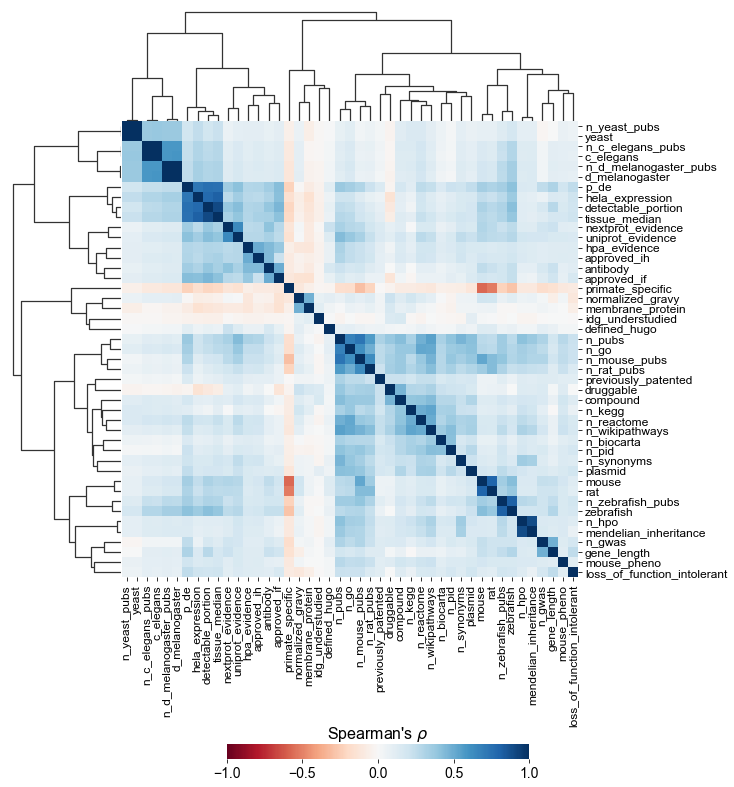

In [50]:
g = sns.clustermap(table_slice.corr(),
                   method='ward', 
                   cmap='RdBu',
                   xticklabels=1, 
                   yticklabels=1,
                   figsize=(10,10), vmin=-1, vmax=1, 
                   cbar_kws={'orientation':'horizontal'}, tree_kws=dict(linewidths=1.25))

g.ax_cbar.set_position((0.32, -0.06, 0.42, 0.02))
g.ax_cbar.set_title(r"Spearman's $\rho$", fontsize=16)
g.ax_cbar.tick_params(labelsize=14)
g.ax_heatmap.tick_params(bottom=True, labelsize=12, axis='x')
g.ax_heatmap.tick_params(bottom=False, labelsize=12, axis='y', labelrotation=0)

plt.savefig('../img/property_clustering_matrix_221117.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/property_clustering_matrix_221117.pdf', bbox_inches='tight')

export.image('general', p='figures/property_clustering_matrix.pdf', date=True)
export.raster_image('general', p='figures/property_clustering_matrix.png', date=True, dpi=600)

Evaulation heatmaps

In [2]:
rename_map={'protein_coding':r'Protein coding$^{††}$',
            'mouse_pheno':'Has associated mouse phenotype', 
                                          'mendelian_inheritance':'Mendelian inheritance',
                                          'mouse':'Homolog in mouse',
                                          'rat':'Homolog in rat',
                                          'c_elegans':'Homolog in C. elegans',
                                          'd_melanogaster':'Homolog in D. melanogaster',
                                          'yeast':'Homolog in yeast',
                                          'zebrafish':'Homolog in zebrafish',
                                          'primate_specific':'Specific to primates',
                                          'nextprot_evidence':'Evidence protein exists (neXtProt)',
                                          'hpa_evidence':'Evidence protein exists (HPA)',
                                          'uniprot_evidence':'Evidence protein exists (UniProt)',
                                          'membrane_protein':'Membrane protein',
                                          'antibody':'Antibody available',
                                          'approved_ih':'Antibody approved (Immunohistochemistry)',
                                          'approved_if':'Antibody approved (Immunofluorescence)',
                                          'idg_understudied':'Understudied according to IDG',
                                          'plasmid':'Plasmid available',
                                          'compound':'Compound known to affect gene activity',
                                          'previously_patented':'Previously patented',
                                          'loss_of_function_intolerant':'Loss of function intolerant',
                                          'druggable':'Druggable',
                                          'defined_hugo':'Defined HGNC nomenclature$^{†}$',
                                          'n_pubs':'Number of articles about gene', 
                                          'n_synonyms':'Number of synonyms', 
                                          'n_gwas':'Number of GWAS annotations', 
                                          'n_biocarta':'Number of BioCarta annotations', 
                                          'n_reactome':'Number of Reactome annotations', 
                                          'n_hpo':'Number of HPO annotations', 
                                          'n_wikipathways':'Number of WikiPathways annotations', 
                                          'n_pid':'Number of PID annotations', 
                                          'n_kegg':'Number of KEGG annotations', 
                                          'n_go':'Number of GO annotations', 
                                          'p_de':'Probability of differential expression', 
                                          'normalized_gravy':'GRAVY score', 
                                          'gene_length':'Gene length', 
                                          'detectable_portion':'Proportion of tissues with detectable RNA expression', 
                                          'tissue_median':'Median RNA expression across tissues', 
                                          'hela_expression':'RNA expression in HeLa', 
                                          'n_mouse_pubs':'Number of articles about mouse homolog', 
                                          'n_rat_pubs':'Number of articles about rat homolog', 
                                          'n_d_melanogaster_pubs':'Number of articles about D. melanogaster homolog', 
                                          'n_zebrafish_pubs':'Number of articles about zebrafish homolog', 
                                          'n_c_elegans_pubs':'Number of articles about C. elegans homolog', 
                                          'n_yeast_pubs':'Number of articles about yeast homolog'}

In [3]:
result_df = pd.read_csv('../data/binary_table_eval_230728.csv')

In [4]:
result_df['property'] = result_df['property'].apply(lambda x: rename_map.get(x))

In [5]:
vals_df = result_df.pivot(index='property', columns='type', values='odds_ratio')
asts_df = result_df.pivot(index='property', columns='type', values='asterisks').fillna('')#.replace('*', r'$\star$')

In [6]:
vals_df = vals_df.rename(columns={'aff_ms':'Aff-MS', 'transcriptomics':'T-omics', 'gwas':'GWAS', 'crispr':'CRISPR'})

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8), 
                         gridspec_kw={'height_ratios': [1,0.05], 'hspace':0.15, 'wspace':1.8})

# binary factors
result_df = pd.read_csv('../data/binary_table_eval_230728.csv')

extra_rows_0 = pd.DataFrame({'type':['gwas', 'crispr', 'transcriptomics', 'aff_ms'], 
                           'property':'defined_hugo', 
                           'odds_ratio':[np.nan,np.inf,np.nan,np.inf], 
                           'asterisks':np.nan})
extra_rows_1 = pd.DataFrame({'type':['gwas', 'crispr', 'transcriptomics', 'aff_ms'], 
                           'property':'protein_coding', 
                           'odds_ratio':[np.nan,np.nan,np.nan,np.nan], 
                           'asterisks':np.nan})
result_df = pd.concat([result_df, extra_rows_0])#, extra_rows_1])
result_df['odds_ratio'] = result_df['odds_ratio'].replace(np.inf, 1000)

result_df['property'] = result_df['property'].apply(lambda x: rename_map.get(x))

vals_df = result_df.pivot(index='property', columns='type', values='odds_ratio')
asts_df = result_df.pivot(index='property', columns='type', values='asterisks').fillna('')#.replace('*', r'$\star$')

vals_df = vals_df.rename(columns={'aff_ms':'Aff-MS', 'transcriptomics':'T-omics', 'gwas':'GWAS', 'crispr':'CRISPR'})

sns.heatmap(np.log2(vals_df), vmin=-2, vmax=2, cmap='Spectral', 
            yticklabels=1, center=0, annot=asts_df, 
            fmt='', annot_kws={'fontsize':16, 'va':'center_baseline'},
           ax=axes[0][0], cbar_ax=axes[1][0],
           cbar_kws={'orientation':'horizontal'})
axes[0][0].tick_params(labelsize=16, labelbottom=False, bottom=False, labeltop=True, top=False, left=False)
axes[0][0].set_xticklabels(labels=axes[0][0].xaxis.get_ticklabels(), 
                             rotation=45, ha='left', va='center', rotation_mode='anchor')
axes[0][0].set_xlabel('')
axes[0][0].set_ylabel('')
axes[1][0].tick_params(labelsize=16)
axes[1][0].set_xticks([-2,0,2])
axes[1][0].set_title(r'log$

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


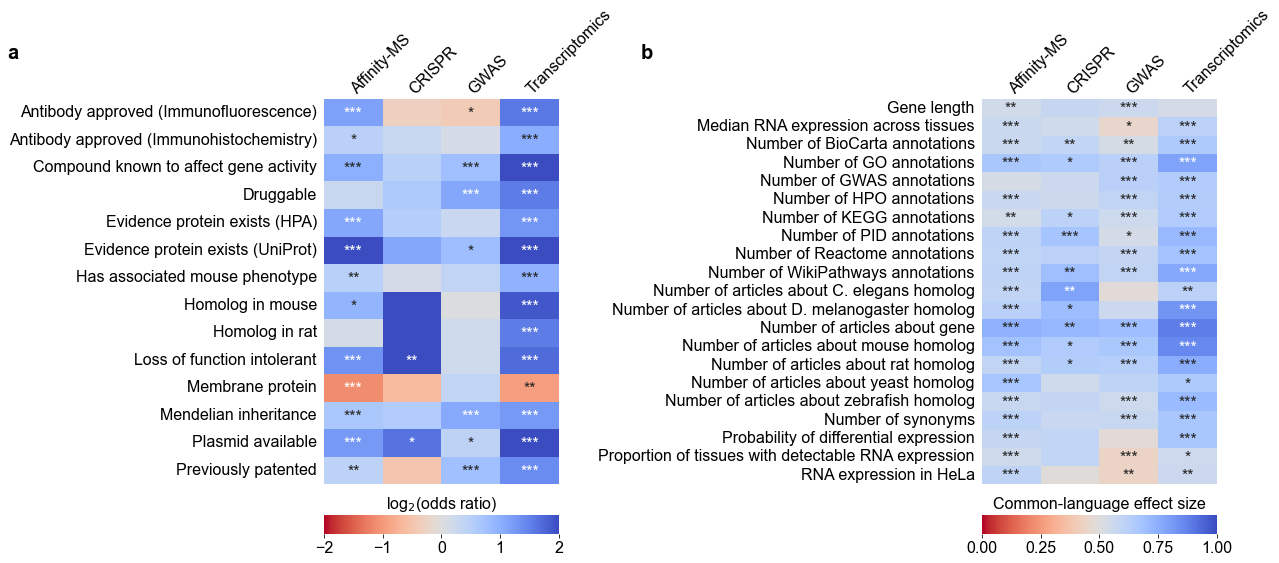

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8), 
                         gridspec_kw={'height_ratios': [1,0.05], 'hspace':0.15, 'wspace':1.8})

# binary factors
result_df = pd.read_csv('../data/binary_table_eval_230728.csv')

extra_rows_0 = pd.DataFrame({'type':['gwas', 'crispr', 'transcriptomics', 'aff_ms'], 
                           'property':'defined_hugo', 
                           'odds_ratio':[np.nan,np.inf,np.nan,np.inf], 
                           'asterisks':np.nan})
extra_rows_1 = pd.DataFrame({'type':['gwas', 'crispr', 'transcriptomics', 'aff_ms'], 
                           'property':'protein_coding', 
                           'odds_ratio':[np.nan,np.nan,np.nan,np.nan], 
                           'asterisks':np.nan})
result_df = pd.concat([result_df, extra_rows_0])#, extra_rows_1])
result_df['odds_ratio'] = result_df['odds_ratio'].replace(np.inf, 1000)

result_df['property'] = result_df['property'].apply(lambda x: rename_map.get(x))

vals_df = result_df.pivot(index='property', columns='type', values='odds_ratio')
asts_df = result_df.pivot(index='property', columns='type', values='asterisks').fillna('')#.replace('*', r'$\star$')

vals_df = vals_df.rename(columns={'aff_ms':'Affinity-MS', 'transcriptomics':'Transcriptomics', 'gwas':'GWAS', 'crispr':'CRISPR'})

vals_df = vals_df[(asts_df == '***').sum(axis=1) > 0]
asts_df = asts_df[(asts_df == '***').sum(axis=1) > 0]

sns.heatmap(np.log2(vals_df.replace(0, 1e-6)), vmin=-2, vmax=2, cmap='coolwarm_r', 
            yticklabels=1, center=0, annot=asts_df, 
            fmt='', annot_kws={'fontsize':16, 'va':'center_baseline'},
           ax=axes[0][0], cbar_ax=axes[1][0],
           cbar_kws={'orientation':'horizontal'})
axes[0][0].tick_params(labelsize=16, labelbottom=False, bottom=False, labeltop=True, top=False, left=False)
axes[0][0].set_xticklabels(labels=axes[0][0].xaxis.get_ticklabels(), 
                             rotation=45, ha='left', va='center', rotation_mode='anchor')
axes[0][0].set_xlabel('')
axes[0][0].set_ylabel('')
axes[1][0].tick_params(labelsize=16)
axes[1][0].set_xticks([-2,-1,0,1,2])
axes[1][0].set_title(r'log$_2$(odds ratio)', fontsize=16)

# continuous factors
result_df = pd.read_csv('../data/continuous_table_eval_230728.csv')

result_df['property'] = result_df['property'].apply(lambda x: rename_map.get(x))

vals_df = result_df.pivot(index='property', columns='type', values='f')
asts_df = result_df.pivot(index='property', columns='type', values='asterisks').fillna('')#.replace('*', r'$\star$')

vals_df = vals_df.rename(columns={'aff_ms':'Affinity-MS', 'transcriptomics':'Transcriptomics', 'gwas':'GWAS', 'crispr':'CRISPR'})

vals_df = vals_df[(asts_df == '***').sum(axis=1) > 0]
asts_df = asts_df[(asts_df == '***').sum(axis=1) > 0]

sns.heatmap(vals_df, vmin=0, vmax=1, cmap='coolwarm_r', 
            yticklabels=1, center=0.5, annot=asts_df, 
            fmt='', annot_kws={'fontsize':16, 'va':'center_baseline'},
           ax=axes[0][1], cbar_ax=axes[1][1],
           cbar_kws={'orientation':'horizontal'})
axes[0][1].tick_params(labelsize=16, labelbottom=False, bottom=False, labeltop=True, top=False, left=False)
axes[0][1].set_xticklabels(labels=axes[0][0].xaxis.get_ticklabels(), 
                             rotation=45, ha='left', va='center', rotation_mode='anchor')
axes[0][1].set_xlabel('')
axes[0][1].set_ylabel('')
axes[1][1].tick_params(labelsize=16)
axes[1][1].set_xticks([0, 0.25, 0.5, 0.75, 1.0])
axes[1][1].set_title('Common-language effect size', fontsize=16)

fig.text(s='a', x=-.15, y=0.95, fontsize=20, weight='bold')
fig.text(s='b', x=0.4, y=0.95, fontsize=20, weight='bold')

plt.savefig('../img/table_eval_figure_230822.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/table_eval_figure_230822.pdf', bbox_inches='tight')

export.image('general', p='figures/table_eval_figure.pdf', date=True)
export.raster_image('general', p='figures/table_eval_figure.png', date=True, dpi=600)

In [15]:
vals_df[(asts_df == '***').sum(axis=1) > 0]

type,Affinity-MS,CRISPR,GWAS,Transcriptomics
property,,,,
Gene length,0.544,0.580,0.565,0.532
Median RNA expression across tissues,0.567,0.548,0.455,0.614
Number of BioCarta annotations,0.570,0.593,0.531,0.655
Number of GO annotations,0.666,0.652,0.619,0.788
Number of GWAS annotations,0.528,0.564,0.619,0.643
Number of HPO annotations,0.573,0.559,0.598,0.640
Number of KEGG annotations,0.540,0.613,0.556,0.647
Number of PID annotations,0.604,0.678,0.532,0.715
Number of Reactome annotations,0.598,0.617,0.590,0.683


In [16]:
result_df = pd.read_csv('../data/binary_table_eval_230728.csv')

extra_rows_0 = pd.DataFrame({'type':['gwas', 'crispr', 'transcriptomics', 'aff_ms'], 
                           'property':'defined_hugo', 
                           'odds_ratio':[np.nan,np.inf,np.nan,np.inf], 
                           'asterisks':np.nan})
extra_rows_1 = pd.DataFrame({'type':['gwas', 'crispr', 'transcriptomics', 'aff_ms'], 
                           'property':'protein_coding', 
                           'odds_ratio':[np.nan,np.nan,np.nan,np.nan], 
                           'asterisks':np.nan})
result_df = pd.concat([result_df, extra_rows_0])#, extra_rows_1])
result_df['odds_ratio'] = result_df['odds_ratio'].replace(np.inf, 1000)

result_df['property'] = result_df['property'].apply(lambda x: rename_map.get(x))

vals_df = result_df.pivot(index='property', columns='type', values='odds_ratio')
asts_df = result_df.pivot(index='property', columns='type', values='asterisks').fillna('')#.replace('*', r'$\star$')

vals_df = vals_df.rename(columns={'aff_ms':'Aff-MS', 'transcriptomics':'T-omics', 'gwas':'GWAS', 'crispr':'CRISPR'})

In [18]:
vals_df.replace(0, 1e-6)

type,Aff-MS,CRISPR,GWAS,T-omics
property,,,,
Antibody approved (Immunofluorescence),2.232e+00,8.120e-01,0.762,3.007e+00
Antibody approved (Immunohistochemistry),1.391e+00,1.235e+00,1.099,2.029e+00
Antibody available,2.617e+00,7.347e-01,0.838,2.357e+00
Compound known to affect gene activity,1.988e+00,1.401e+00,1.734,4.331e+00
Defined HGNC nomenclature$^{†}$,1.000e+03,1.000e+03,NaN,NaN
Druggable,1.232e+00,1.529e+00,2.156,2.948e+00
Evidence protein exists (HPA),2.143e+00,1.450e+00,1.224,2.432e+00
Evidence protein exists (UniProt),5.412e+00,2.153e+00,1.755,5.385e+00
Evidence protein exists (neXtProt),5.305e+00,7.503e-01,1.075,3.048e+00


In [127]:
result_df = pd.read_csv('../data/binary_table_eval_230728.csv')

In [128]:
result_df['property'] = result_df['property'].apply(lambda x: rename_map.get(x))

In [129]:
vals_df = result_df.pivot(index='property', columns='type', values='odds_ratio')
asts_df = result_df.pivot(index='property', columns='type', values='asterisks').fillna('')#.replace('*', r'$\star$')

In [130]:
vals_df = vals_df.rename(columns={'aff_ms':'Aff-MS', 'transcriptomics':'T-omics', 'gwas':'GWAS', 'crispr':'CRISPR'})

In [115]:
from __future__ import unicode_literals

In [59]:
vals_df

type,Aff-MS,CRISPR,GWAS,T-omics
property,,,,
Antibody approved (Immunofluorescence),2.232,0.812,0.762,3.007
Antibody approved (Immunohistochemistry),1.391,1.235,1.099,2.029
Antibody available,2.617,0.735,0.838,2.357
Compound known to affect gene activity,1.988,1.401,1.734,4.331
Druggable,1.232,1.529,2.156,2.948
Evidence protein exists (HPA),2.143,1.450,1.224,2.432
Evidence protein exists (UniProt),5.412,2.153,1.755,5.385
Evidence protein exists (neXtProt),5.305,0.750,1.075,3.048
Has associated mouse phenotype,1.401,1.097,1.299,1.971


In [7]:
table['log_n_pubs'] = np.log10(table['n_pubs']+1)

<AxesSubplot:xlabel='membrane_protein', ylabel='log_n_pubs'>

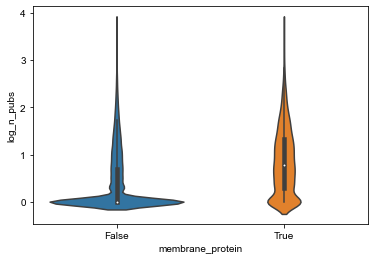

In [8]:
sns.violinplot(data=table, x='membrane_protein', y='log_n_pubs')

In [10]:
table['membrane_protein'].sum()

5380